# City, Pollutant -> Coal Index Granger Causality

This notebook investigates whether air pollution levels in a city are statistically linked to the China Coal Production Index, using Granger causality tests, correlation analysis, cross-correlation plots, time series visualization (original and differenced). The code can be adapted to do the analysis with any monthly economic time series.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests

# Load China Coal Index data
coal_df = (
    pd.read_csv('anup_data/ChinaCoal.csv', parse_dates=['Date'])
      .set_index('Date')
      .sort_index()
      .rename(columns={'Coal Production Index': 'CoalIdx'})
      .loc["2014-01-01":"2025-07-01"]
)
coal_df.index += pd.Timedelta(days=1)

def cross_correlation_lags(series_x, series_y, max_lag=12, title=None):
    """
    Compute and plot the cross-correlation function (CCF) of two aligned series.
    series_x leads -> positive lag means X affects Y later
    """
    # Ensure same index and drop missing
    data = pd.concat([series_x, series_y], axis=1).dropna()
    x = (data.iloc[:, 0] - data.iloc[:, 0].mean()) / data.iloc[:, 0].std()
    y = (data.iloc[:, 1] - data.iloc[:, 1].mean()) / data.iloc[:, 1].std()

    lags = range(-max_lag, max_lag + 1)
    ccf_values = [x.corr(y.shift(-lag)) for lag in lags]  # shift y backward to test if x leads y

    # Create plot
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(lags, ccf_values, width=0.8)
    ax.axhline(0, color='gray', linewidth=0.8, linestyle='--')
    ax.set_xlabel('Lag (months)')
    ax.set_ylabel('Cross-correlation')
    ax.set_title(title or 'Cross-correlation between variables')
    ax.grid(True)
    plt.tight_layout()
    plt.show()

    # Report strongest correlation lag
    max_corr = max(ccf_values, key=abs)
    best_lag = lags[ccf_values.index(max_corr)]
    print(f"Max cross-correlation: {max_corr:.2f} at lag {best_lag} months")
    return pd.Series(ccf_values, index=lags)


def quick_analysis(city, pollutant, use_diff=False):
    # Load pollutant data
    city_df = pd.read_csv(
        f"umn_bootcamp_capstone_project/data/aqicn/{city}.csv", # ADAPT TO CORRECT FILE PATHS
        usecols=['date', pollutant],
        parse_dates=['date'],
        skipinitialspace=True
    )
    city_df[pollutant] = pd.to_numeric(city_df[pollutant], errors='coerce')

    # Compute monthly average
    monthly_pollutant_orig = (
        city_df
        .assign(month=city_df['date'].dt.to_period('M').dt.to_timestamp())
        .groupby('month')[pollutant]
        .mean()
        .rename(f'monthly_avg_{pollutant}')
        .to_frame()
    )

    # Align with coal index
    coal_orig = coal_df[['CoalIdx']].copy()

    # Plot original time series
    fig, ax1 = plt.subplots(figsize=(10, 5))
    monthly_pollutant_orig.plot(ax=ax1, lw=2, color='red', label=f'{pollutant} ({city})')
    ax1.set_ylabel(pollutant)
    ax1.set_xlabel('Date')

    ax2 = ax1.twinx()
    coal_orig['CoalIdx'].plot(ax=ax2, lw=2, color='black', label='China Coal Index')
    ax2.set_ylabel('Coal Production Index')

    # Combined legend
    lines = ax1.get_lines() + ax2.get_lines()
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='upper left')
    ax1.set_title(f'{pollutant.upper()} in {city.title()} vs China Coal Index (Original)')
    fig.tight_layout()
    plt.show()

    # Differencing if requested
    if use_diff:
        monthly_pollutant_diff = monthly_pollutant_orig.diff().dropna()
        coal_diff = coal_orig.diff().dropna()
        pollutant_data = monthly_pollutant_diff
        coal_data = coal_diff
    else:
        pollutant_data = monthly_pollutant_orig
        coal_data = coal_orig

    # Combine datasets for analysis
    combined = pd.concat([pollutant_data, coal_data], axis=1).dropna()

    # Plot differenced series if differencing applied
    if use_diff:
        fig, ax1 = plt.subplots(figsize=(10, 5))
        pollutant_data.plot(ax=ax1, lw=2, color='orange', label=f'Diff {pollutant} ({city})')
        ax1.set_ylabel(f'Δ {pollutant}')
        ax1.set_xlabel('Date')

        ax2 = ax1.twinx()
        coal_data.plot(ax=ax2, lw=2, color='gray', label='Diff China Coal Index')
        ax2.set_ylabel('Δ Coal Index')

        lines = ax1.get_lines() + ax2.get_lines()
        labels = [line.get_label() for line in lines]
        ax1.legend(lines, labels, loc='upper left')
        ax1.set_title(f'{pollutant.upper()} in {city.title()} vs Coal Index (Differenced)')
        fig.tight_layout()
        plt.show()

    # Correlation
    corr = combined.corr().iloc[0, 1]
    print(f'Correlation between {pollutant} and CoalIdx: {corr:.2f}')

    # Granger causality: Does pollutant ➜ coal index?
    gc_res = grangercausalitytests(combined[['CoalIdx', f'monthly_avg_{pollutant}']], maxlag=12, verbose=False)

    results = [
        {'lag': lag, 'F': res[0]['ssr_ftest'][0], 'p': res[0]['ssr_ftest'][1]}
        for lag, res in gc_res.items()
    ]
    gc_df = pd.DataFrame(results).set_index('lag')
    print(gc_df.round(4))

    # Cross-correlation analysis
    print(f"\nCross-correlation: Does {pollutant} lead/lag coal index?")
    cross_correlation_lags(
        series_x=coal_data['CoalIdx'],
        series_y=pollutant_data[f'monthly_avg_{pollutant}'],
        max_lag=12,
        title=f"Cross-Correlation: Δ{pollutant.upper()} vs ΔCoal Index ({city})" if use_diff else f"{pollutant.upper()} vs Coal Index ({city})"
    )

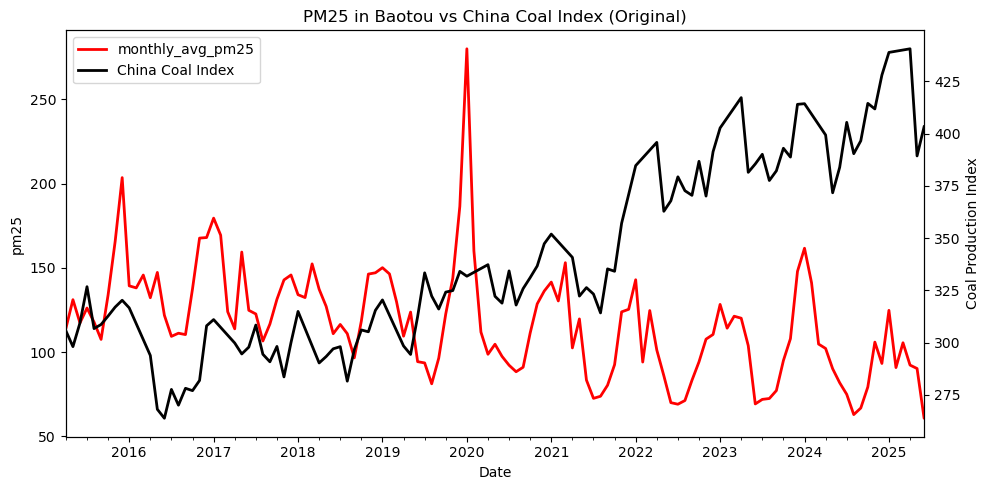

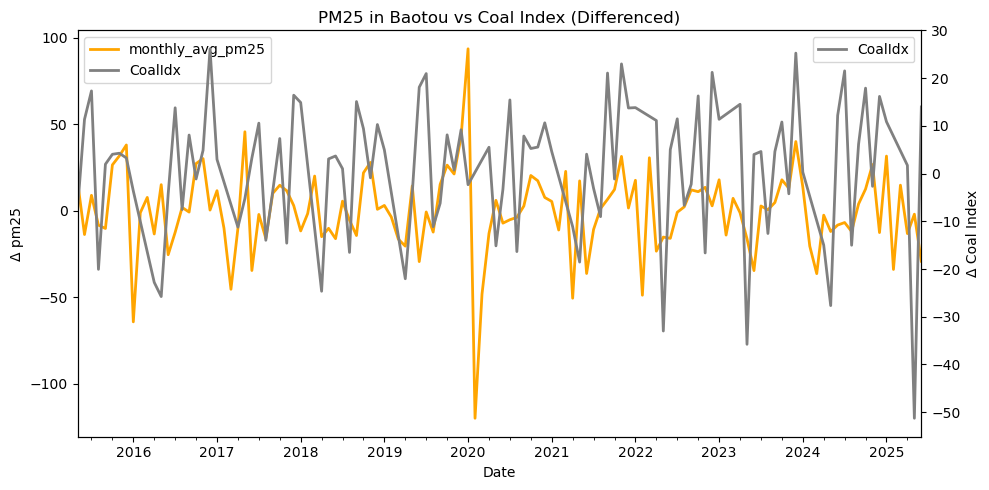

Correlation between pm25 and CoalIdx: 0.14
          F       p
lag                
1    6.3699  0.0132
2    5.6614  0.0048
3    4.7889  0.0038
4    4.3031  0.0031
5    3.6140  0.0051
6    3.0308  0.0099
7    2.5127  0.0218
8    1.7237  0.1062
9    2.2873  0.0252
10   1.3291  0.2322
11   1.1535  0.3356
12   1.0414  0.4233

Cross-correlation: Does pm25 lead/lag coal index?


/home/daniel/Documents/IMA_Bootcamp/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


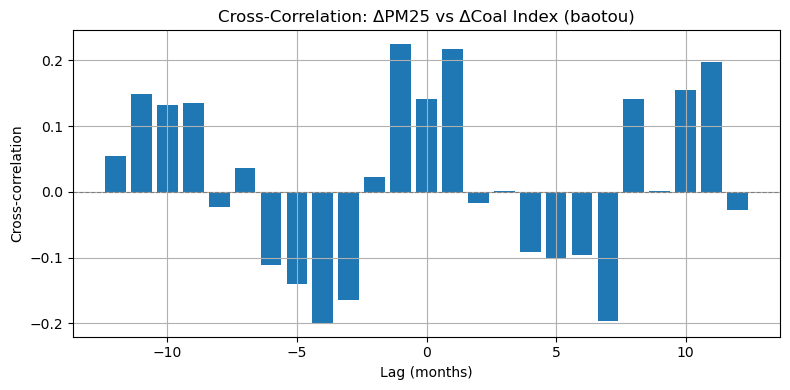

Max cross-correlation: 0.22 at lag -1 months


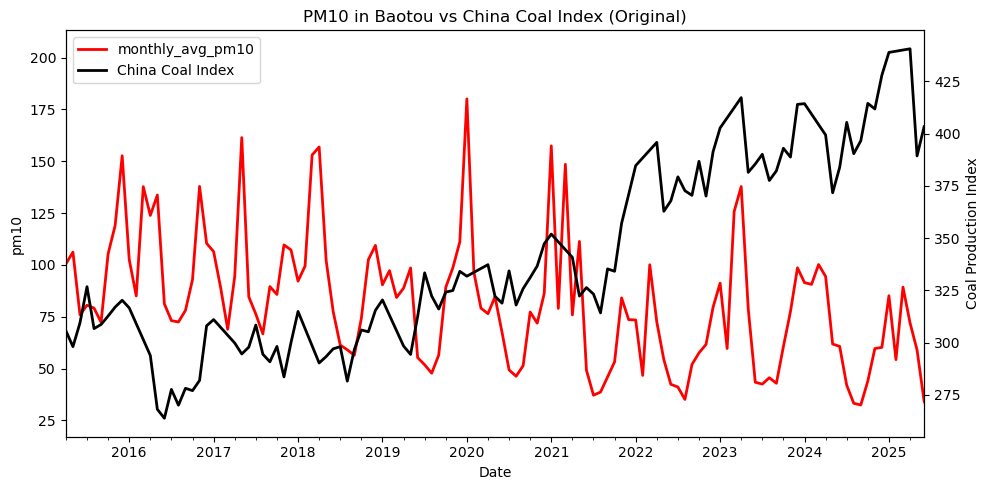

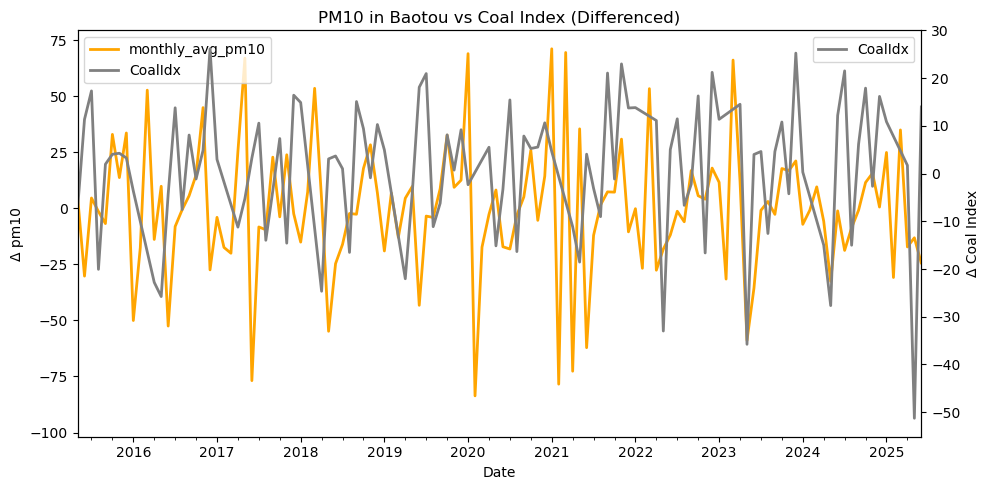

Correlation between pm10 and CoalIdx: 0.09
          F       p
lag                
1    3.0863  0.0821
2    3.5821  0.0316
3    3.0009  0.0346
4    2.8685  0.0276
5    3.3093  0.0088
6    2.9698  0.0112
7    3.0103  0.0074
8    2.0124  0.0559
9    3.3933  0.0016
10   1.8674  0.0644
11   1.5365  0.1389
12   1.4048  0.1867

Cross-correlation: Does pm10 lead/lag coal index?


/home/daniel/Documents/IMA_Bootcamp/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


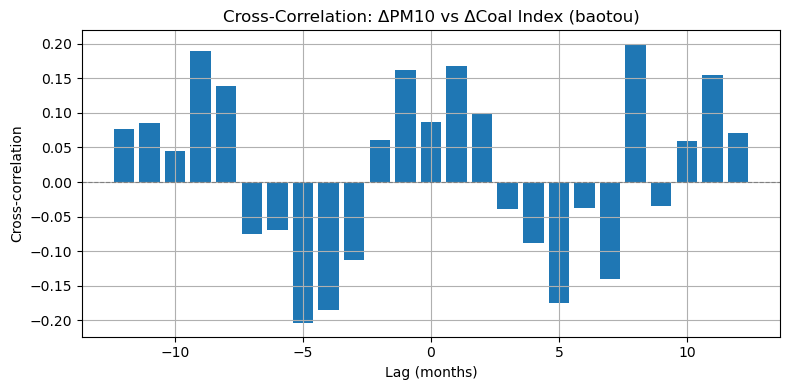

Max cross-correlation: -0.20 at lag -5 months


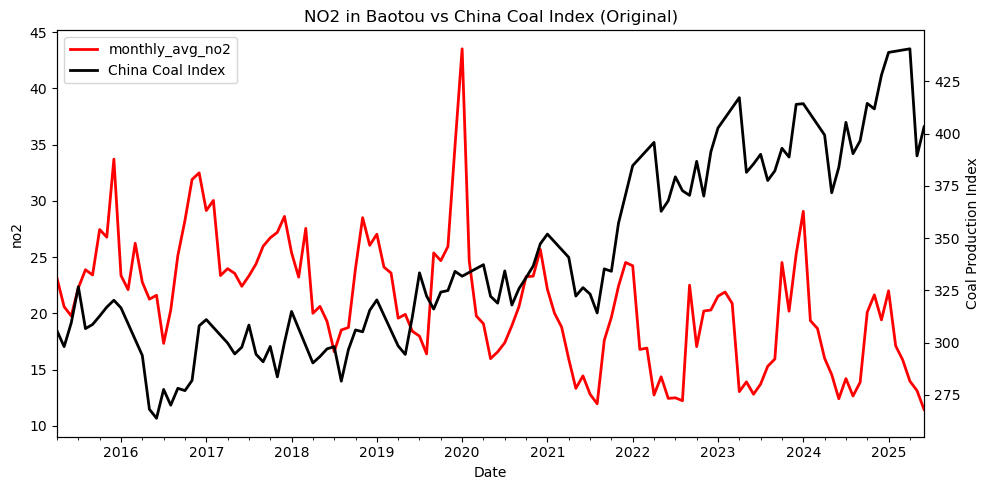

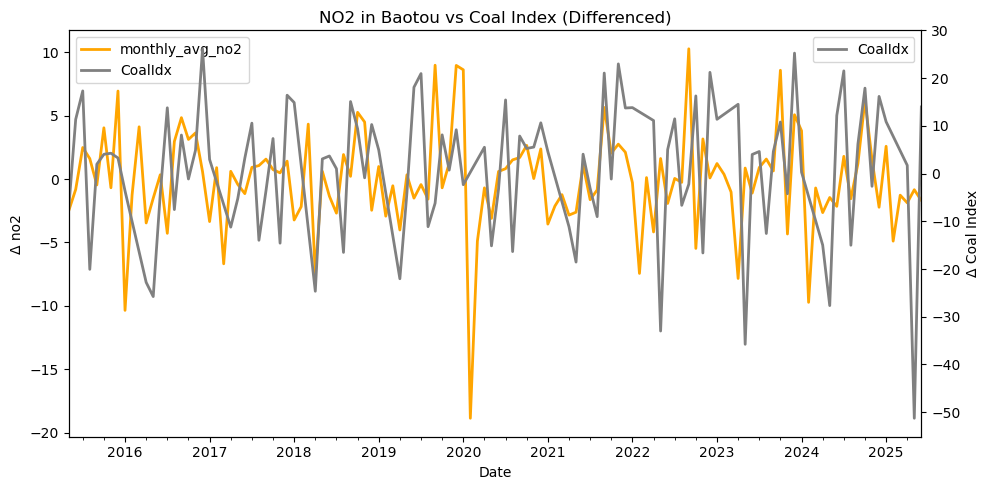

Correlation between no2 and CoalIdx: 0.15
           F       p
lag                 
1    11.3882  0.0011
2     7.4813  0.0010
3     5.9310  0.0010
4     4.7257  0.0017
5     3.1604  0.0115
6     3.8096  0.0021
7     3.4394  0.0029
8     3.0608  0.0048
9     3.0126  0.0041
10    1.8003  0.0761
11    1.6356  0.1084
12    1.2694  0.2582

Cross-correlation: Does no2 lead/lag coal index?


/home/daniel/Documents/IMA_Bootcamp/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


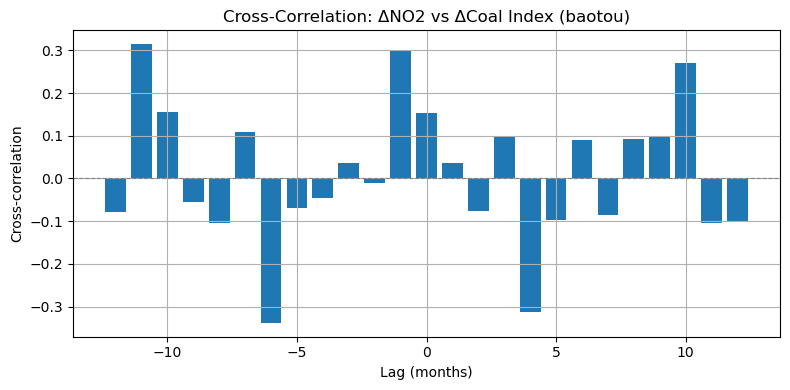

Max cross-correlation: -0.34 at lag -6 months


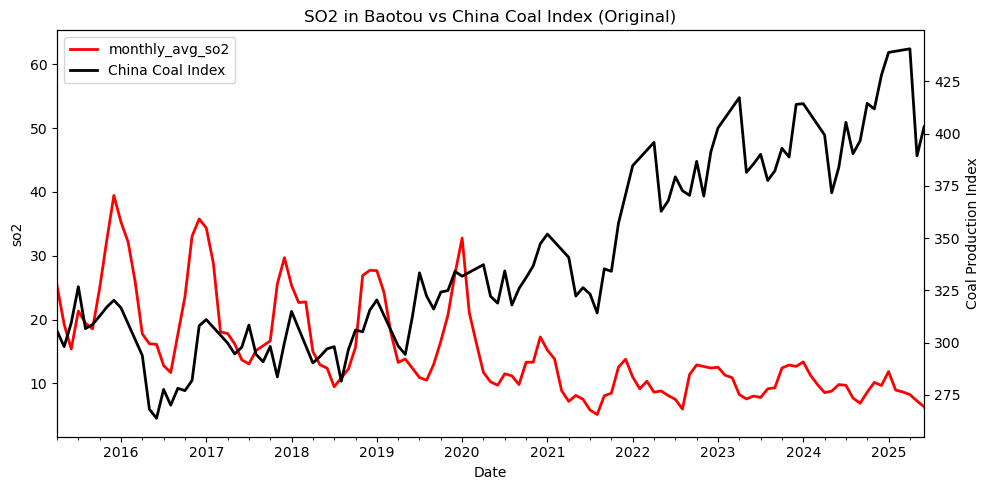

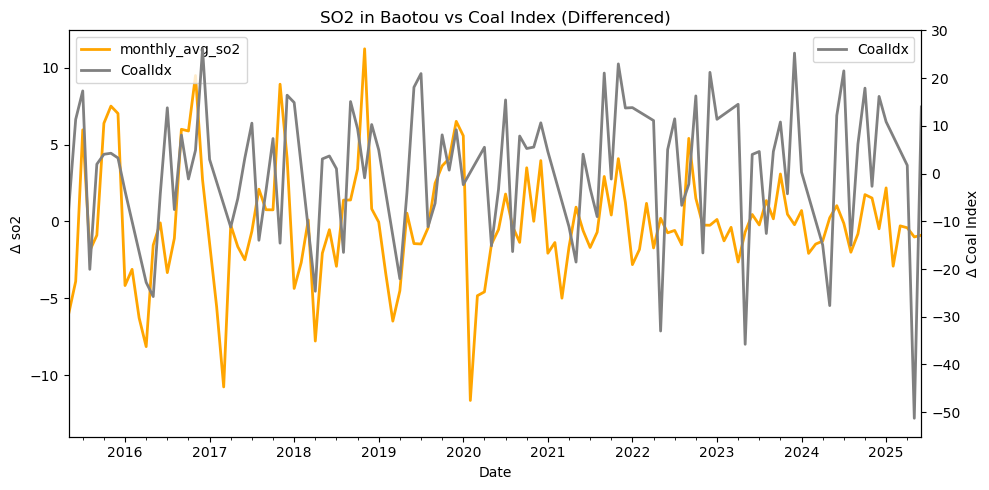

Correlation between so2 and CoalIdx: 0.21
           F       p
lag                 
1    10.0023  0.0021
2     6.3516  0.0026
3     5.2915  0.0021
4     4.4706  0.0024
5     3.2929  0.0091
6     2.5949  0.0236
7     2.3700  0.0297
8     1.5047  0.1695
9     1.4180  0.1960
10    1.2311  0.2867
11    0.8687  0.5742
12    0.9225  0.5302

Cross-correlation: Does so2 lead/lag coal index?


/home/daniel/Documents/IMA_Bootcamp/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


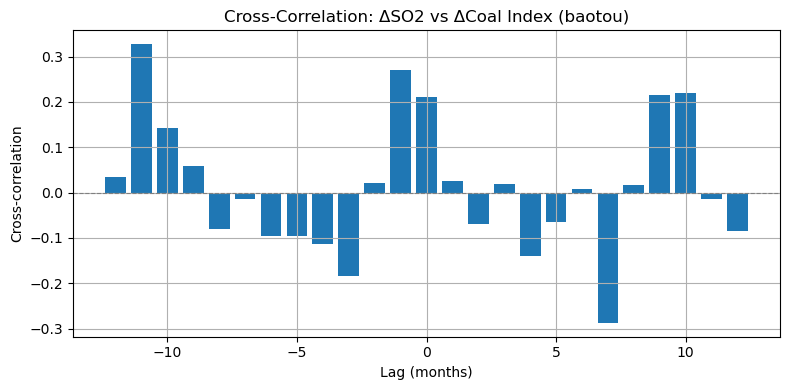

Max cross-correlation: 0.33 at lag -11 months


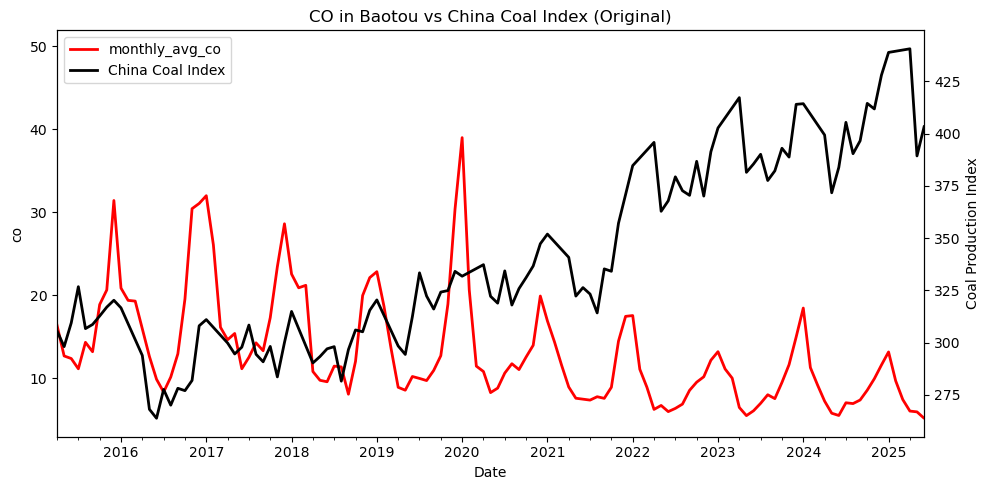

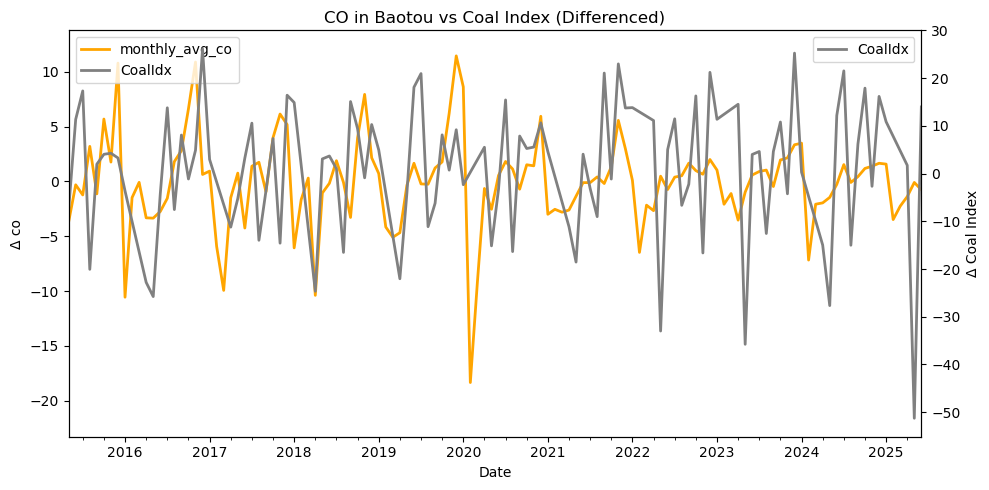

Correlation between co and CoalIdx: 0.23
           F       p
lag                 
1    12.2328  0.0007
2     8.8553  0.0003
3     7.2784  0.0002
4     5.0622  0.0010
5     3.7301  0.0042
6     3.5735  0.0034
7     2.9168  0.0091
8     1.9578  0.0632
9     1.9456  0.0583
10    0.9806  0.4680
11    0.8337  0.6074
12    0.6711  0.7725

Cross-correlation: Does co lead/lag coal index?


/home/daniel/Documents/IMA_Bootcamp/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


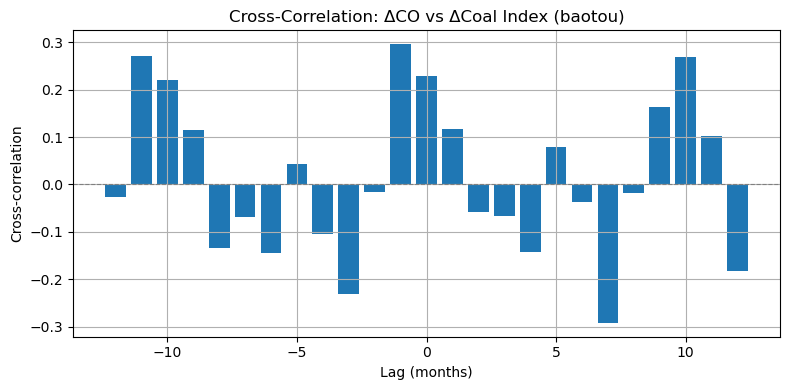

Max cross-correlation: 0.30 at lag -1 months


In [9]:
cities = ["baotou", "beijing, west park", "chengdu", "chongqing", "ganzhou", "guangzhou", "kunming", "panzhihua", "quanzhou", "shanghai", "shenzhen", "shuozhou", "tangshan", "wuhan"]

for pollutant in ["pm25", "pm10", "no2", "so2", "co"]:
    quick_analysis("baotou", pollutant, use_diff = True)